# 基于Keras的MNIST手写体识别

In [1]:
from keras.models import Sequential  # 采用贯序模型
from keras.layers import Input, Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from keras.models import Model
from keras import metrics
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
import numpy as np

Using TensorFlow backend.
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1type

## 1.读取MNIST手写体数据集

In [2]:
# 读取mnist手写体数据集    
def load_data(path='./datasets/mnist.npz'):
    f = np.load(path)
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']
    f.close()
    return (x_train, y_train), (x_test, y_test)

## 2.创建一个模型
可以从下面每一个模型中选择一个

### 2.1. 全部采用全连接层：

In [14]:
model = Sequential() # 采用贯序模型
   
# Dense 这是第一个隐藏层，并附带定义了输入层，该隐含层有500个神经元。输入则是 784个节点
# input Layer   输入层
model.add(Dense(500,input_shape=(784,))) # 输入层，28*28=784 输入层将二维矩阵换成了一维向量输入
model.add(Activation('tanh')) # 激活函数是tanh 为双曲正切  tanh(x) = sinh(x)/cosh(x) = (e^x - e^(-x))/(e^x + e^(-x))
model.add(Dropout(0.5)) # 采用50%的dropout  随机取一半进行训练
 
    
#Dense Layer   隐藏层
model.add(Dense(500)) # 隐藏层节点500个
model.add(Activation('tanh'))
model.add(Dropout(0.5))
 
#Dense Layer   隐藏层
model.add(Dense(500))
model.add(Activation('tanh'))

 
#output layer  输出层
model.add(Dense(10)) # 输出结果是10个类别，所以维度是10
model.add(Activation('softmax')) # 最后一层用softmax作为激活函数
model_name = 'DNN'

### 2.2. 使用经典的LeNet网络：

In [3]:
model = Sequential()
model.add(Conv2D(input_shape=(28, 28, 1), kernel_size=(5, 5), filters=20, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))

model.add(Conv2D(kernel_size=(5, 5), filters=50,  activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(10, activation='softmax'))
model_name = "LeNet"

Instructions for updating:
Colocations handled automatically by placer.


### 读入MNIST数据集，根据网络类型的不同，处理数据集

In [15]:
(X_train, Y_train), (X_test, Y_test) = load_data('./datasets/mnist.npz') 
if model_name == 'LeNet':
    X_train = X_train.reshape(-1, 28, 28, 1)  # normalize
    X_test = X_test.reshape(-1, 28, 28, 1)      # normalize
    X_train = X_train / 255
    X_test = X_test / 255
    Y_train = np_utils.to_categorical(Y_train, num_classes=10)
    Y_test = np_utils.to_categorical(Y_test, num_classes=10)
elif model_name == 'DNN':
    # 由于mist的输入数据维度是(num, 28, 28)，这里需要把后面的维度直接拼起来变成784维
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

    #这个能生成一个OneHot的10维向量，作为Y_train的一行，这样Y_train就有60000行OneHot作为输出
    Y_train = (np.arange(10) == Y_train[:, None]).astype(int)  # 整理输出
    Y_test = (np.arange(10) == Y_test[:, None]).astype(int)    #np.arange(5) = array([0,1,2,3,4])

## 3. 选择优化器与参数，编译模型
注：修改了优化器后，请将model.compile()内的参数optimizer修改为对应的优化器，如：sgd,adam。

#### 优化器选择

In [19]:
#   lr：大于0的浮点数，学习率
#   momentum：大于0的浮点数，动量参数
#   decay：大于0的浮点数，每次更新后的学习率衰减值
#   nesterov：布尔值，确定是否使用Nesterov动量
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) # 设定优化器的对应参数
tBatchSize = 128        # 选择每次传入模型的图片数量

In [16]:
#   lr：大于0的浮点数，学习率
#   beta_1: float, 0 < beta < 1. 通常接近于 1。
#   decay：大于0的浮点数，每次更新后的学习率衰减值
adam = Adam(lr=0.001, beta_1=0.9, decay=1e-6)
tBatchSize = 128

#### 模型编译

In [20]:
# 只有通过了编译，model才真正的建立起来，这时候才能够被使用
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=[metrics.categorical_accuracy]) # 使用交叉熵作为loss函数  

## 训练模型  
model.fit的一些参数  
batch_size：对总的样本数进行分组，每组包含的样本数量  
epochs ：训练次数  
shuffle：是否把数据随机打乱之后再进行训练  
validation_split：拿出百分之多少用来做交叉验证  
verbose：屏显模式 0：不输出  1：输出进度  2：输出每次的训练结果

In [21]:
model.fit(X_train, Y_train, batch_size=tBatchSize, epochs=5, shuffle=True, validation_split=0.3)
model.save('./models/my_model.h5')

Train on 42000 samples, validate on 18000 samples
Epoch 1/5
42000/42000 [==============================] - 3s 62us/step - loss: 0.6758 - categorical_accuracy: 0.7764 - val_loss: 0.3266 - val_categorical_accuracy: 0.8989
Epoch 2/5
42000/42000 [==============================] - 2s 42us/step - loss: 0.5256 - categorical_accuracy: 0.8271 - val_loss: 0.2810 - val_categorical_accuracy: 0.9103
Epoch 3/5
42000/42000 [==============================] - 2s 42us/step - loss: 0.4753 - categorical_accuracy: 0.8465 - val_loss: 0.2562 - val_categorical_accuracy: 0.9181
Epoch 4/5
42000/42000 [==============================] - 2s 42us/step - loss: 0.4462 - categorical_accuracy: 0.8554 - val_loss: 0.2524 - val_categorical_accuracy: 0.9196
Epoch 5/5
42000/42000 [==============================] - 2s 42us/step - loss: 0.4352 - categorical_accuracy: 0.8587 - val_loss: 0.2269 - val_categorical_accuracy: 0.9278


## 模型误差评价

In [19]:
# 误差评价 ：按batch计算在batch用到的输入数据上模型的误差
scores,accuracy = model.evaluate(X_test,Y_test, batch_size=tBatchSize, verbose=0)
print("The test loss is %f" % scores,"The test accuracy is %f" % accuracy)

The test loss is 0.465440 The test accuracy is 0.848400


## 可视化模型的测试效果
运行此cell前，需要先运行读入MNIST数据集的cell

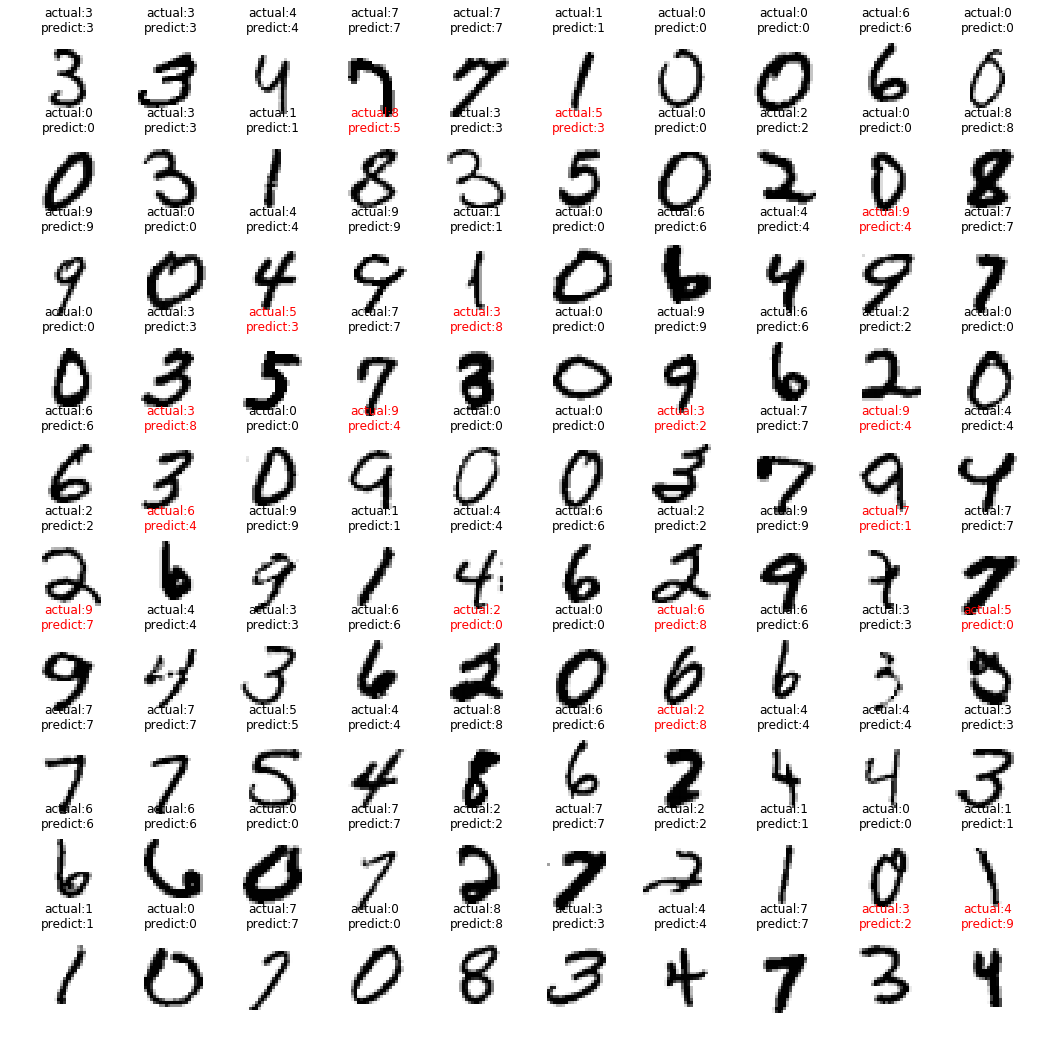

In [23]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from keras.models import load_model

def drawDigit3(position, image, title, isTrue):
    plt.subplot(*position)
    plt.imshow(image.reshape(-1, 28), cmap='gray_r')
    plt.axis('off')
    if not isTrue:
        plt.title(title, color='red')
    else:
        plt.title(title)
        
# 读取mnist手写体数据集    
def load_data(path='./datasets/mnist.npz'):
    f = np.load(path)
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']
    f.close()
    return (x_train, y_train), (x_test, y_test)
        
def batchDraw3(batch_size, test_X, test_y):
    
    selected_index = random.sample(range(len(test_y)), k=batch_size)
    images = test_X[selected_index]
    labels = test_y[selected_index]
    model = load_model('./models/my_model.h5')
    predict_labels = model.predict(images)
    image_number = images.shape[0]
    row_number = math.ceil(image_number ** 0.5)
    column_number = row_number
    plt.figure(figsize=(row_number+8, column_number+8))
    for i in range(row_number):
        for j in range(column_number):
            index = i * column_number + j
            if index < image_number:
                position = (row_number, column_number, index+1)
                image = images[index]
                actual = np.argmax(labels[index])
                predict = np.argmax(predict_labels[index])
                isTrue = actual==predict
                title = 'actual:%d\npredict:%d' %(actual,predict)
                drawDigit3(position, image, title, isTrue)

batchDraw3(100, X_test, Y_test)
plt.show()